# This script plots the shared weigths evaluation

In [1]:
import vae_tools.sanity
import vae_tools.loader
vae_tools.sanity.check()
import numpy as np
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)


# Matplotlib
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}')
import matplotlib
import matplotlib.pyplot as plt

from itertools import product
import pandas as pd
import glob
import pickle

python version:  3.5.2
keras version: 2.2.4-tf
tensorflow version: 2.0.2
matplotlib uses:  module://ipykernel.pylab.backend_inline
No GPUs available


/home/twbadmin/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


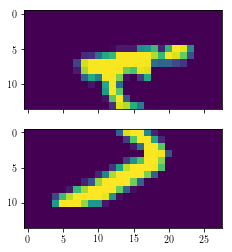

In [2]:


# Get the split MNIST digits
(x_train_a, x_train_b), (x_test_a, x_test_b), y_train, y_test = vae_tools.loader.mnist_split(flatten = True, split = 'hor')

# Show a split image

img_rows, img_cols = 28, 28

f, ax = plt.subplots(2,1,sharex=True)
ax[0].imshow(x_train_a[0,:].reshape(((int(img_rows/2), img_cols))))
ax[1].imshow(x_train_b[0,:].reshape(((int(img_rows/2), img_cols))))
plt.show()


In [3]:
import astetik


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rcParams


def corr(data,
         ax,
         mask=True,
         line_width=1,
         line_color='black',
         color_grades=5,
         size=8.5,
         annot = True,
         despine = False,
         tight = True):


    # # # # # PREP STARTS # # # # #
    if mask == True:
        mask = np.zeros_like(data)
        mask[np.triu_indices_from(mask)] = True
        line_color = 'white'
    else:
        mask = None
    # # # # # PREP ENDS # # # # #

    # HEADER STARTS >>>
    palette = sns.color_palette("RdBu_r", n_colors=color_grades)
    rcParams['figure.facecolor'] = (1, 1, 1, 0) #  'transparent'
    rcParams['axes.facecolor'] = (1, 1, 1, 0) #'transparent'
    rcParams['savefig.facecolor'] = (1, 1, 1, 0) #'transparent'

    # PLOT
    ax = sns.heatmap(data,
                    mask=mask,
                    vmin=-100, vmax=100,
                    linewidths=line_width,
                    linecolor=line_color,
                    cmap=palette,
                    square=True,
                    annot=annot,
                    cbar=False,
                    annot_kws = {'size':6},
                    ax=ax)

    # DESPINE THE FIGURE
    if despine == True:
        try:
            p.spines['bottom'].set_color('black')
        except:
            pass
        sns.despine(left=True, right=True, top=True)

    # FORCE TIGHT LAYOUT
    if tight == True:
        plt.tight_layout()

    ax.set_xticklabels(data, rotation=45, ha='right', size=8, color='k')
    ax.set_yticklabels(data, rotation=0, size=8, color='k')

    return p, ax


def norm_heatmap(d, ax, max_cols = 21):
    len_col = len(d.columns)
    if len_col * 1.5 > max_cols:
        print("WARNING: Choose a higher max_cols value for all plots, or reduce the number of columns")
    fac = len_col / max_cols
    bbox = ax.get_position()
    ax.set_position([bbox.x0 + (1 - fac) / 2 * bbox.width, bbox.y0 + (1 - fac) / 2 * bbox.height,
                     fac * bbox.width, fac * bbox.height])

def latex_sanitizer(df):
    #import re
    #p = re.compile(r'[\W_]')
    map = {}
    for c in df.columns:
        #map[c] = p.sub('a', c)
        map[c] = c.replace(r'_', r' ')
    print(map)
    return df.rename(columns=map)

def jsd(a, b):
    return r'$\text{D}_{\text{JS}}(\text{' + a + r'}\|\text{' + b + r'})$'
def gnb(a, b):
    return r'$^{\text{' + a + r'}}P_{\text{' + b + r'}}$'

In [4]:
h_prefix = 'h_'


def load_dfs(dump_loc):
    # get the history
    df = pd.read_hdf(dump_loc + 'history.h5', key='df', mode='r+')

    # Load the JSD and average it over all samples
    prefix = 'jsd_'
    jsd = None
    for idx in df['index']:
        loc = dump_loc + 'jsd_' + str(idx) + '_ab.p'
        data = pickle.load( open( loc, "rb" ) )
        if jsd is None:
            jsd = {}
            for k in data.keys():
                jsd[prefix + k] = []
        for k in data.keys():
            #print(np.mean(js[k]))
            jsd[prefix + k].append(np.mean(data[k]))
    # Add the JSD to the pandas data frame
    df_jsd = pd.DataFrame(jsd, columns=jsd.keys())

    # Load the GNB classifications and calculate the precision

    gnb = None
    prefix = 'gnb_prec_'
    denom = len(y_test)
    for idx in df['index']:
        loc = dump_loc + 'bayes_classifier_' + str(idx) + '.p'
        data = pickle.load( open( loc, "rb" ) )
        if gnb is None:
            gnb = {}
            for k in data.keys():
                gnb[prefix + k] = []
        for k in data.keys():
            #print(np.mean(js[k]))
            gnb[prefix + k].append(np.sum((data[k] == y_test))/denom)
    # Add the JSD to the pandas data frame
    df_gnb = pd.DataFrame(gnb, columns=gnb.keys())

    return df, df_jsd, df_gnb

def get_df(dump_loc_prefix):
    df_lst, df_jsd_lst, df_gnb_lst = [], [], []

    for seed in range(5):
        dump_loc = dump_loc_prefix + str(seed) + "/"
        df, df_jsd, df_gnb = load_dfs(dump_loc)
        df_lst.append(df)
        df_jsd_lst.append(df_jsd)
        df_gnb_lst.append(df_gnb)

    df = pd.concat(df_lst, axis =0)
    df_jsd = pd.concat(df_jsd_lst, axis =0)
    df_gnb = pd.concat(df_gnb_lst, axis =0)

    return pd.concat([df, df_jsd, df_gnb], axis =1) # .reset_index()


## Show the correlation matrix

{'h_list_val_loss_prior_1': 'h list val loss prior 1', 'h_list_loss_reconstruction_1_0': 'h list loss reconstruction 1 0', 'latent_intermediate_dim': 'latent intermediate dim', 'gnb_prec_a_ab': 'gnb prec a ab', 'beta_mutual': 'beta mutual', 'h_loss_mutual_avg': 'h loss mutual avg', 'gnb_prec_b_a': 'gnb prec b a', 'gnb_prec_a_a': 'gnb prec a a', 'h_list_loss_reconstruction_0_0': 'h list loss reconstruction 0 0', 'h_loss_reconstruction_avg': 'h loss reconstruction avg', 'h_list_loss_prior_2': 'h list loss prior 2', 'gnb_prec_a_b': 'gnb prec a b', 'jsd_train_ab_vs_b': 'jsd train ab vs b', 'h_list_loss_reconstruction_2_0': 'h list loss reconstruction 2 0', 'h_list_val_loss_mutual_1': 'h list val loss mutual 1', 'h_loss_prior_avg': 'h loss prior avg', 'h_list_loss_prior_0': 'h list loss prior 0', 'z_dim': 'z dim', 'h_list_val_loss': 'h list val loss', 'h_list_val_loss_reconstruction_0_0': 'h list val loss reconstruction 0 0', 'shared_weights': 'shared weights', 'jsd_train_b_vs_a': 'jsd trai

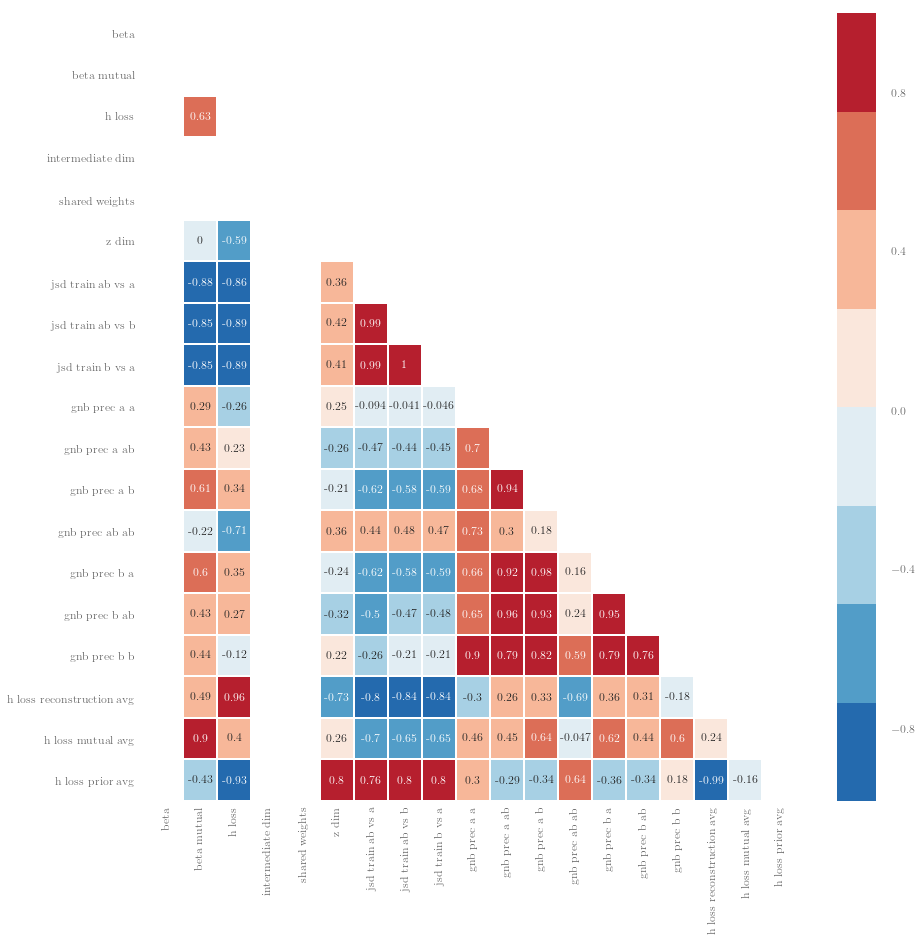

In [141]:
# make beta-mutual linear
#_df['beta_mutual'] = _df['beta_mutual'].apply(lambda x: int(np.log10(x)))
#_df = _df[_df['beta_mutual'] != int(1)]

def cleanup_df(_df):
    # correlation w/o validation
    _df = _df.drop(["activation","reconstruction_loss_metrics","optimizer","index","seed","epochs","batch_size"], axis=1)
    #_df = _df.drop(["gnb_prec_a_a", "gnb_prec_ab_ab", "gnb_prec_b_b", "gnb_prec_ab_a", "gnb_prec_ab_b"], axis=1)
    _df = _df.drop(["gnb_prec_ab_a", "gnb_prec_ab_b"], axis=1)
    _df = _df.drop(["jsd_train_ab_vs_ab"], axis=1)
    _df = _df.drop(["lr"], axis=1)
    _df = _df[[c for c in _df.columns if c[:5] != 'h_val']]
    _df = _df[[c for c in _df.columns if c[:8] != 'jsd_test']]

    # mean of reconstruction losses
    __df = _df[[c for c in _df.columns if c[:21] == 'h_loss_reconstruction']]
    _df = _df[[c for c in _df.columns if c[:21] != 'h_loss_reconstruction']]
    _df['h_loss_reconstruction_avg'] = __df.mean(axis=1)

    # mean of mutual losses
    __df = _df[[c for c in _df.columns if c[:13] == 'h_loss_mutual']]
    _df = _df[[c for c in _df.columns if c[:13] != 'h_loss_mutual']]
    _df['h_loss_mutual_avg'] = __df.mean(axis=1)

    # mean of prior losses
    __df = _df[[c for c in _df.columns if c[:12] == 'h_loss_prior']]
    _df = _df[[c for c in _df.columns if c[:12] != 'h_loss_prior']]
    _df['h_loss_prior_avg'] = __df.mean(axis=1)
    return _df.drop(["beta", "intermediate_dim", "shared_weights", "h_loss", "gnb_prec_b_a", "gnb_prec_b_b", "gnb_prec_b_ab"], axis=1)

#astetik.corr(latex_sanitizer(_df), color_grades=5, style='astetik', annot=True)


def renamer(data):
    data = data.rename(columns={"jsd train ab vs a": jsd(r'ab', r'a')})
    data = data.rename(columns={"jsd train ab vs b": jsd(r'ab', r'b')})
    data = data.rename(columns={"jsd train b vs a": jsd(r'a', r'b')})
    #data = data.rename(columns={"gnb prec a ab": gnb(r'a', r'ab')})
    data = data.rename(columns={"gnb prec a ab": gnb(r'bi.\!', r'uni.')})
    data = data.rename(columns={"gnb prec b ab": gnb(r'b', r'ab')})
    #data = data.rename(columns={"gnb prec ab ab": gnb(r'ab', r'ab')})
    data = data.rename(columns={"gnb prec ab ab": gnb(r'', r'bi.')})
    #data = data.rename(columns={"gnb prec a a": gnb(r'a', r'a')})
    data = data.rename(columns={"gnb prec a a": gnb(r'', r'uni.')})
    data = data.rename(columns={"gnb prec b b": gnb(r'b', r'b')})
    #data = data.rename(columns={"gnb prec a b": gnb(r'a', r'b')})
    data = data.rename(columns={"gnb prec a b": gnb(r'uni.\!', r'uni.')})
    data = data.rename(columns={"gnb prec b a": gnb(r'b', r'a')})
    data = data.rename(columns={"h loss": r'J'})
    data = data.rename(columns={"h loss reconstruction avg": r'$\overline{\text{rec.}}$'})
    data = data.rename(columns={"h loss mutual avg": r'$\overline{\text{D}_{\text{KL}}(\cdot \| \cdot)}$'})
    data = data.rename(columns={"h loss prior avg": r'$\overline{\text{D}_{\text{KL}}(\cdot \| p(z))}$'})
    data = data.rename(columns={"z dim": r"$D_{z}$"})
    data = data.rename(columns={"beta mutual": r"$\beta_{\text{M}}$"})
    return data

{'h_list_val_loss_prior_1': 'h list val loss prior 1', 'h_list_loss_reconstruction_1_0': 'h list loss reconstruction 1 0', 'gnb_prec_a_ab': 'gnb prec a ab', 'beta_mutual': 'beta mutual', 'h_loss_mutual_avg': 'h loss mutual avg', 'gnb_prec_a_a': 'gnb prec a a', 'h_list_loss_reconstruction_0_0': 'h list loss reconstruction 0 0', 'h_loss_reconstruction_avg': 'h loss reconstruction avg', 'h_list_loss_prior_2': 'h list loss prior 2', 'gnb_prec_a_b': 'gnb prec a b', 'jsd_train_ab_vs_b': 'jsd train ab vs b', 'h_list_loss_reconstruction_2_0': 'h list loss reconstruction 2 0', 'h_list_val_loss_mutual_1': 'h list val loss mutual 1', 'h_loss_prior_avg': 'h loss prior avg', 'h_list_loss_prior_0': 'h list loss prior 0', 'z_dim': 'z dim', 'h_list_val_loss': 'h list val loss', 'h_list_val_loss_reconstruction_0_0': 'h list val loss reconstruction 0 0', 'jsd_train_b_vs_a': 'jsd train b vs a', 'jsd_train_ab_vs_a': 'jsd train ab vs a', 'h_list_val_loss_mutual_0': 'h list val loss mutual 0', 'h_list_loss_

/home/twbadmin/.local/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


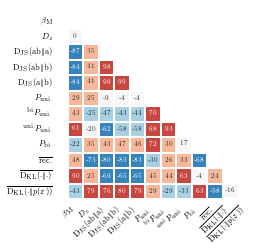

In [156]:

#dump_loc_prefix = '/mnt/ssd_pcie/mmvae_mnist_split_3/' # shared weights
dump_loc_prefix = '/mnt/ssd_pcie/mmvae_mnist_split_4/' # non-shared weights

data = renamer(latex_sanitizer(cleanup_df(get_df(dump_loc_prefix))))

#data = latex_sanitizer(_df)
data = data.corr(method='spearman').mul(100).fillna(-101).astype('int32', errors='raise')
data[data < -100] = np.NaN

cm2inch = 1/2.54
figsize_x_cm = 15
figsize_y_cm = 15
figsize = (figsize_x_cm*cm2inch, figsize_y_cm*cm2inch)
p, ax = plt.subplots(figsize=figsize)

p, ax = corr(data, ax, color_grades=5, annot = True, despine = False)
norm_heatmap(data, ax, max_cols = 21)
#ax.set_xticklabels([r'$\beta_{\text{M}}$', r'$J$', r'$D_{z}$', 'foooooo'])
p.savefig('/mnt/ssd_pcie/repositories/vae_tools/examples/mmvae_mnist_split/corr_shared_weights_false.pdf')
p.show()
#_df